[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GP248CME215/Curve-fitting/blob/main/Curve_fitting_1D.ipynb)





In [1]:
##############################################################################################################
# RUN THIS CODE BLOCK FIRST, it will load dependencies / install them if your system does not already have them.
##############################################################################################################

# tensorflow
try:
    # Try to import TensorFlow
    import tensorflow as tf
    print(f"TensorFlow is already installed. Version: {tf.__version__}")
except ImportError as e:
    # TensorFlow is not installed; install it
    print("TensorFlow is not installed. Installing TensorFlow...")
    !pip install tensorflow
    import tensorflow as tf
    print(f"Successfully installed TensorFlow. Version: {tf.__version__}")

# pyDOE
try:
    # Try to import pyDOE
    import pyDOE
    print(f"pyDOE is already installed.")
except ImportError as e:
    # pyDOE is not installed; install it
    print("pyDOE is not installed. Installing pyDOE...")
    !pip install pyDOE
    import pyDOE
    print(f"Successfully installed pyDOE.")

import tensorflow_probability as tfp
from tensorflow.keras.layers import InputLayer, Dense, Layer
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
import time

np.random.seed(123)
tf.random.set_seed(123)


TensorFlow is already installed. Version: 2.18.0
pyDOE is not installed. Installing pyDOE...
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=bd45a0e9abc4b954d7f4ebbf9c3c3ad6281a4658ce9e944db90a1db6c1556eda
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [2]:
print("Below are the versions that this Colab notebook uses:")
print("Python version: " + sys.version)
print("matplotlib version: " + matplotlib.__version__)
print("TensorFlow version: " + tf.__version__)

print("")

print("Below are the versions that successfully run this script:")
print("Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]")
print("matplotlib version: 3.7.1")
print("TensorFlow version: 2.15.0")

Below are the versions that this Colab notebook uses:
Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
matplotlib version: 3.10.0
TensorFlow version: 2.18.0

Below are the versions that successfully run this script:
Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
matplotlib version: 3.7.1
TensorFlow version: 2.15.0


In [3]:
class NeuralNet:
    # Initialize the class
    def __init__(self, t_train, x_train, t_test, x_test, layers, t_min, t_max):
        self.t_train = t_train
        self.x_train = x_train
        self.t_test = t_test
        self.x_test = x_test
        self.loss_history = {"train": [], "test": []}

        # Initialize NNs with given number of layers and domain bounds [t_min, tmax]
        self.t_min = t_min
        self.t_max = t_max
        self.initialize_nn(layers)

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def initialize_nn(self, layers):
        """Functions used to establish the initial neural network"""
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32))
            weights.append(W)
            biases.append(b)
        self.weights = weights
        self.biases = biases
        self.trainable_variables = self.weights + self.biases

    def net(self, X):
        H = 2.0 * (X - self.t_min) / (self.t_max - self.t_min) - 1.0
        for l in range(0, len(self.weights) - 1):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    @tf.function
    def loss_train(self):
        x_pred = self.net(self.t_train)
        loss = tf.reduce_mean(tf.square(self.x_train - x_pred)) * 10
        return loss

    @tf.function
    def loss_test(self):
        x_pred = self.net(self.t_test)
        loss = tf.reduce_mean(tf.square(self.x_test - x_pred)) * 10
        return loss

    def get_test_error(self):
        x_pred = self.net(self.t_test)
        error_x = tf.norm(self.x_test - x_pred, 2) / tf.norm(self.x_test, 2)
        return error_x

    def train(self, nIter: int, learning_rate: float, idxOpt: int):
      """Function used for training the model"""
      if idxOpt == 1:
          # mode 1: running the Gradient Descent optimization
          self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
      elif idxOpt == 2:
          # mode 2: running the Adam optimization
          self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      else:
          raise ValueError("Unsupported idxOpt")

      varlist = self.trainable_variables
      start_time = time.time()

      for it in range(nIter):
          with tf.GradientTape() as tape:
              loss_value = self.loss_train()

          # Compute gradients
          gradients = tape.gradient(loss_value, varlist)

          # Apply gradients
          self.optimizer.apply_gradients(zip(gradients, varlist))

          # Print training progress
          if it % 100 == 0:
              elapsed = time.time() - start_time
              loss_train = loss_value.numpy()
              loss_test = self.loss_test().numpy()
              self.loss_history["train"].append(loss_train)
              self.loss_history["test"].append(loss_test)
              print('It: %d, Train Loss: %.3e, Test Loss: %.3e, Time: %.2f' %
                    (it, loss_train, loss_test, elapsed))
              start_time = time.time()


%matplotlib inline
def plot(t_all, x_all, pred_all, t_train, x_train, title: str):
    fig = plt.figure(figsize=(21, 24))

    ax = plt.subplot(311)
    ax.plot(t_all, x_all, "r", label="Exact Solution")
    ax.plot(t_all, pred_all, "b--", label="Prediction")
    ax.scatter(t_train, x_train, s=30, c="g", label="Training Data Point")
    ax.legend()
    ax.set_xlabel("$t$", fontsize = 15)
    ax.set_ylabel("$x$", fontsize = 15, rotation = 0)
    ax.set_title("$Fitting$", fontsize = 15)

    ax = plt.subplot(312)
    ax.plot(t_all, pred_all - x_all, "b-")
    ax.set_xlabel("$t$", fontsize = 15)
    ax.set_ylabel("Prediction - Exact Solution", fontsize = 15, rotation = 90)
    ax.set_title("Difference between Prediction and Exact Solution", fontsize = 15)

    ax = plt.subplot(313)
    loss_train = np.array(model.loss_history["train"])
    loss_test = np.array(model.loss_history["test"])
    ax.scatter(np.arange(loss_train.size) * 100, loss_train, s=30, marker="x", label="Train Loss")
    ax.scatter(np.arange(loss_train.size) * 100, loss_test, s=30, marker="+", label="Test Loss")
    ax.legend()
    ax.set_xlabel("$iterations$", fontsize = 15)
    ax.set_ylabel("Loss", fontsize = 15, rotation = 90)
    ax.set_yscale("log")
    ax.set_title('Loss Curve', fontsize = 15)

    plt.gcf().text(0.02, 0.9, title, fontsize=30)

It: 0, Train Loss: 5.157e+00, Test Loss: 5.352e+00, Time: 0.17
It: 100, Train Loss: 4.822e+00, Test Loss: 5.560e+00, Time: 1.84
It: 200, Train Loss: 4.775e+00, Test Loss: 5.555e+00, Time: 2.75
It: 300, Train Loss: 4.820e-01, Test Loss: 6.330e-01, Time: 2.07
It: 400, Train Loss: 1.122e-03, Test Loss: 1.745e-03, Time: 0.96
It: 500, Train Loss: 5.123e-04, Test Loss: 1.153e-03, Time: 0.84
It: 600, Train Loss: 5.069e-04, Test Loss: 1.142e-03, Time: 0.84
It: 700, Train Loss: 5.016e-04, Test Loss: 1.132e-03, Time: 0.84
It: 800, Train Loss: 4.965e-04, Test Loss: 1.122e-03, Time: 0.85
It: 900, Train Loss: 4.915e-04, Test Loss: 1.112e-03, Time: 0.85
It: 1000, Train Loss: 4.866e-04, Test Loss: 1.103e-03, Time: 0.83
It: 1100, Train Loss: 4.819e-04, Test Loss: 1.094e-03, Time: 0.96
It: 1200, Train Loss: 4.773e-04, Test Loss: 1.086e-03, Time: 1.15
It: 1300, Train Loss: 4.728e-04, Test Loss: 1.077e-03, Time: 1.18
It: 1400, Train Loss: 4.684e-04, Test Loss: 1.069e-03, Time: 0.84
It: 1500, Train Loss: 

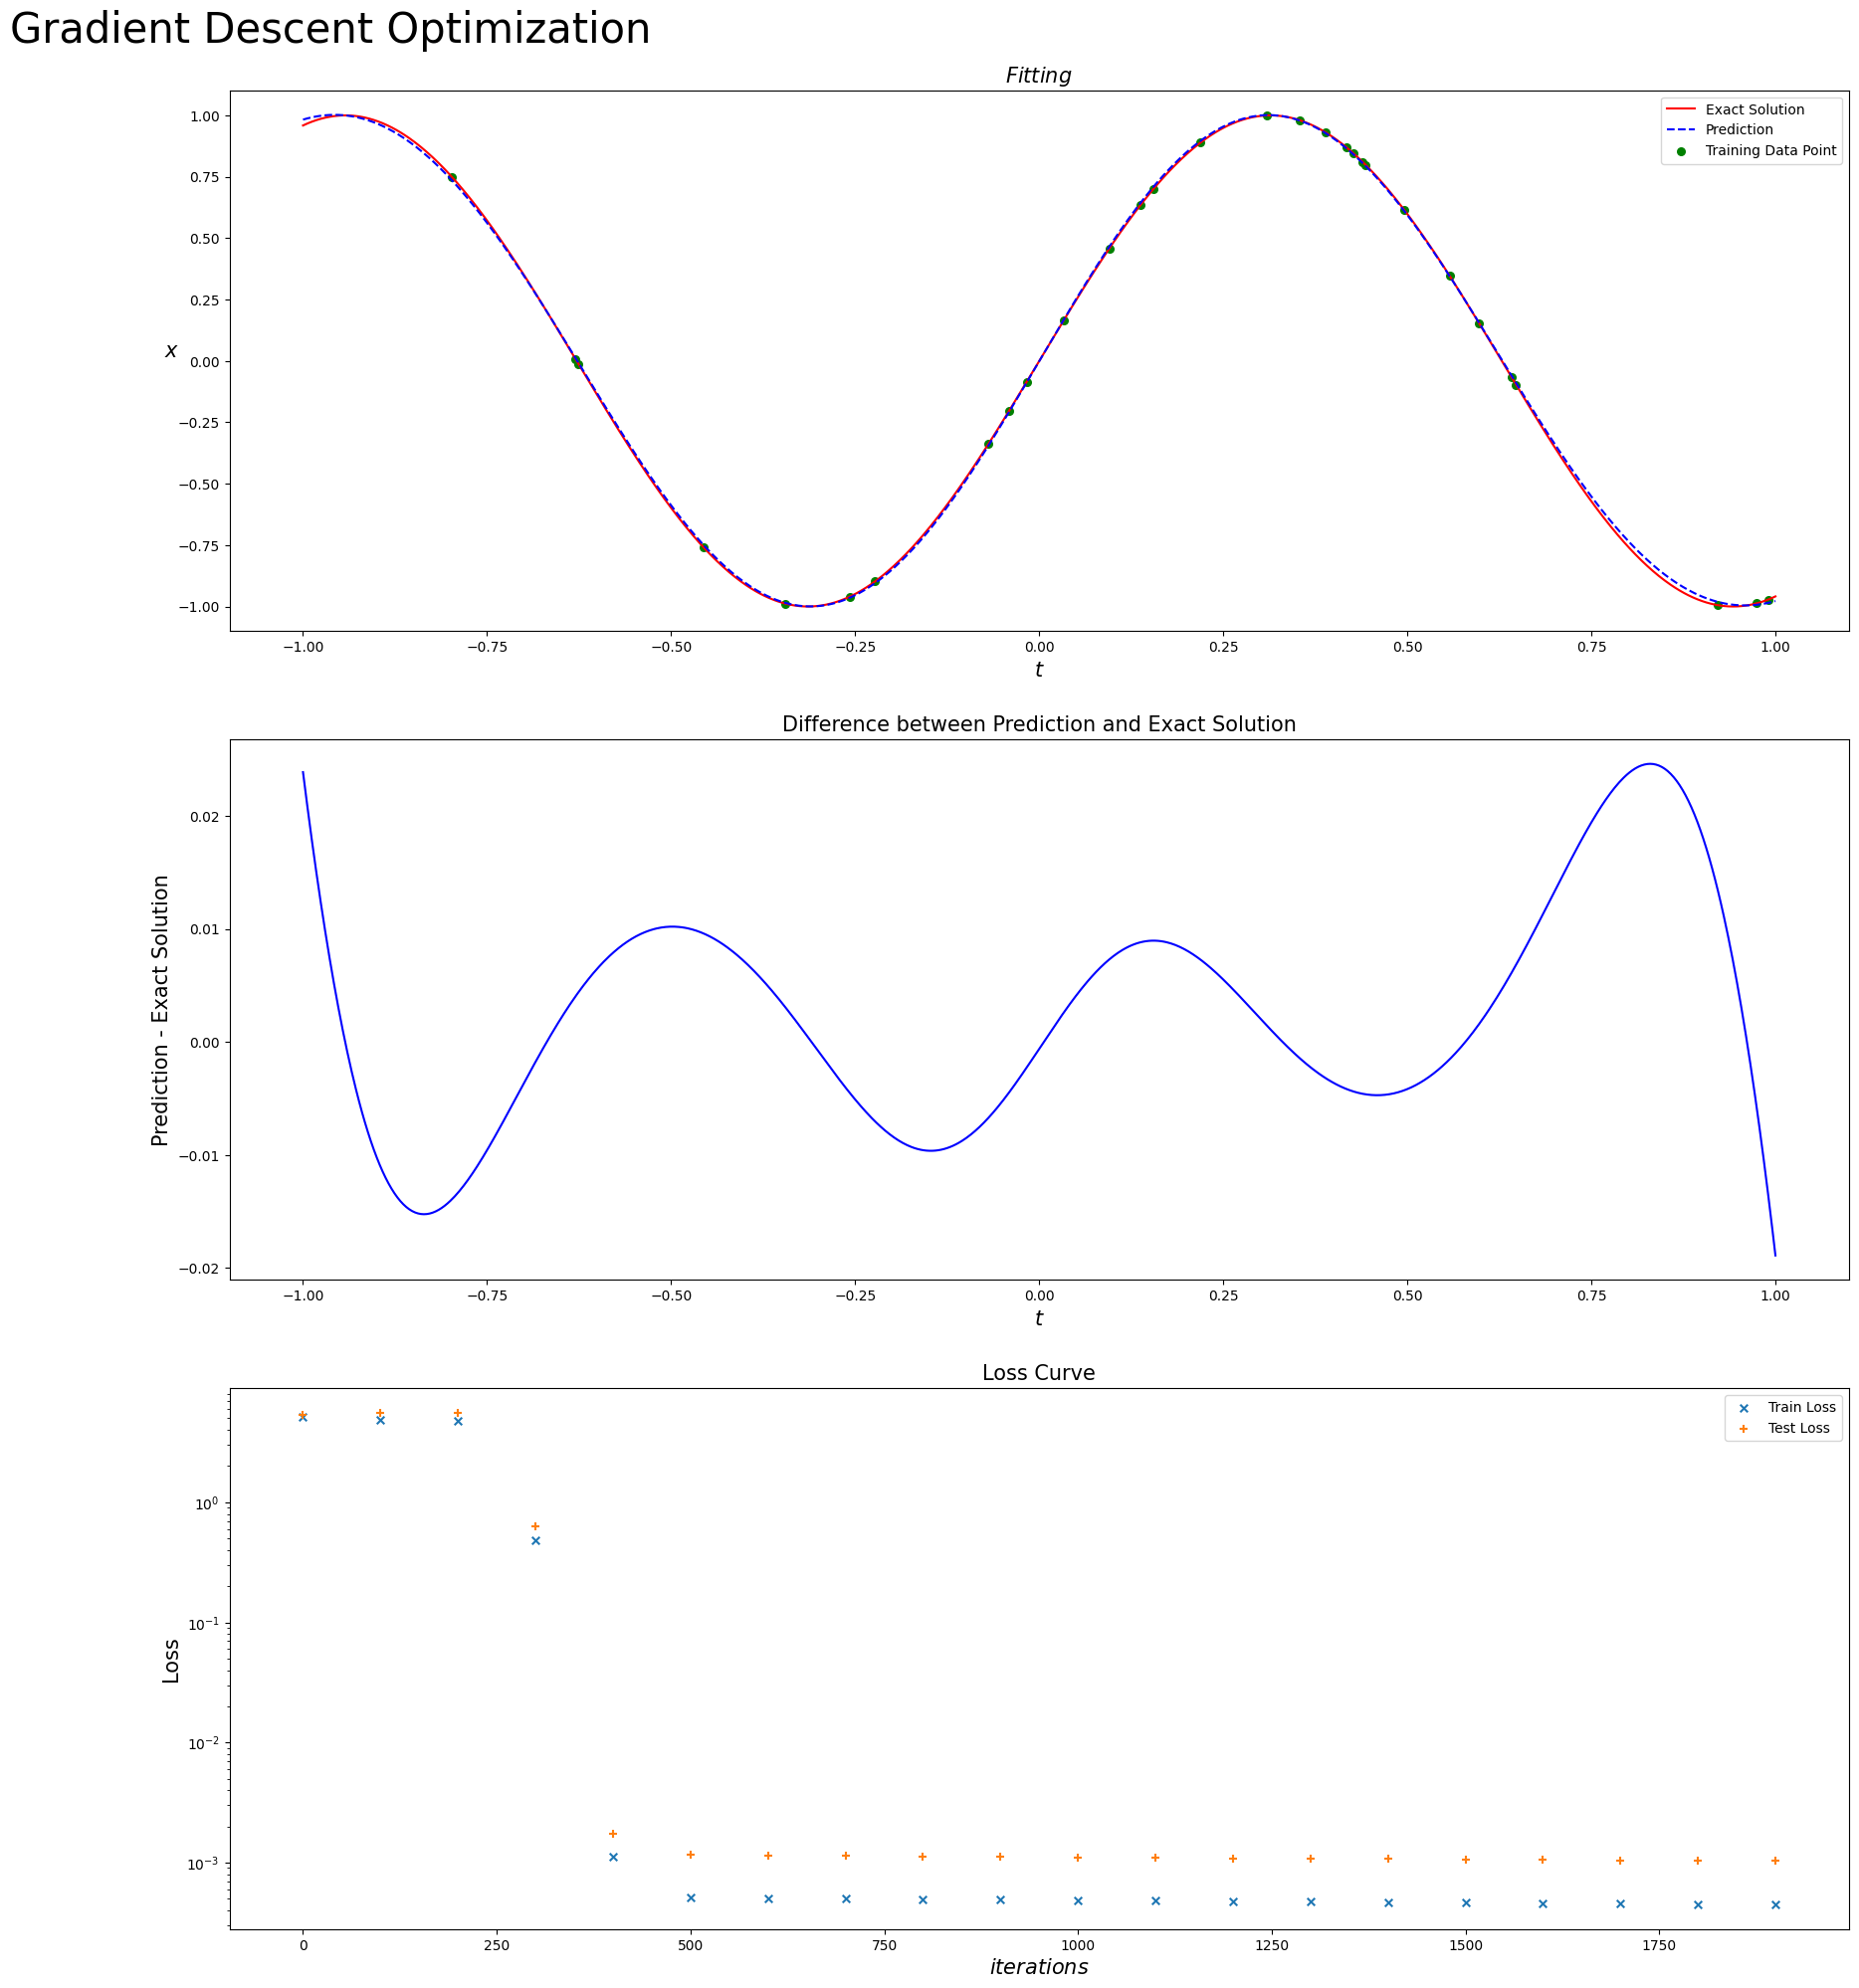

In [20]:
# Create data points and get random split of train, test data sets by index slicing
n_total = 1000
train_ratio = 0.03
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
x_all = x = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices]
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[1, 100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()
model.train(2000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

plot(t_all, x_all, pred_all, t_train, x_train, title="Gradient Descent Optimization")

### Tasks
1. Find the learning rate that makes the loss converge
2. Find the minimum amount of training data needed to make the loss converge
3. Effects of activation function
4. Effects of noisy data (e.g. Gausian noise)
5. Find the parameters that can cause overfitting (test loss increases over iterations). The maximum iterations you can use is 20k.

1. A learning rate of 0.01 is a suitable learning rate, so that the problem converges. The inital rate of 0.1 was too high, so that the loss function varied a lot and would not converge. When I tried, 0.001 it was too small that the problem was not changing enough for the loss to converge.

2. In general it appears you need 30 data points for a good NN prediction. This corresponds to a training ratio of 0.03. If you choose a smaller training ratio, then the NN prediction will vary a lot when increasing the ratio. However, when you increase further than 0.03 there is not much change in the NN prediction.

# Question 3

When changing the activation function to tanh, the data no longer fits as well. When using this as an activation function we will likley need to increasing the training ratio to ensure we get a good NN prediction.

It: 0, Train Loss: 4.096e+00, Test Loss: 5.060e+00, Time: 0.78
It: 100, Train Loss: 3.618e+00, Test Loss: 5.176e+00, Time: 1.07
It: 200, Train Loss: 3.615e+00, Test Loss: 5.173e+00, Time: 0.84
It: 300, Train Loss: 3.613e+00, Test Loss: 5.171e+00, Time: 0.81
It: 400, Train Loss: 3.611e+00, Test Loss: 5.168e+00, Time: 1.10
It: 500, Train Loss: 3.608e+00, Test Loss: 5.165e+00, Time: 0.84
It: 600, Train Loss: 3.603e+00, Test Loss: 5.158e+00, Time: 0.82
It: 700, Train Loss: 3.580e+00, Test Loss: 5.125e+00, Time: 0.85
It: 800, Train Loss: 2.660e+00, Test Loss: 3.840e+00, Time: 0.82
It: 900, Train Loss: 4.669e-01, Test Loss: 5.650e-01, Time: 0.82
It: 1000, Train Loss: 1.913e-01, Test Loss: 2.059e-01, Time: 0.82
It: 1100, Train Loss: 3.668e-01, Test Loss: 3.339e-01, Time: 0.84
It: 1200, Train Loss: 4.154e-01, Test Loss: 3.597e-01, Time: 0.82
It: 1300, Train Loss: 3.340e-01, Test Loss: 2.931e-01, Time: 1.18
It: 1400, Train Loss: 2.923e-01, Test Loss: 2.586e-01, Time: 1.29
It: 1500, Train Loss: 

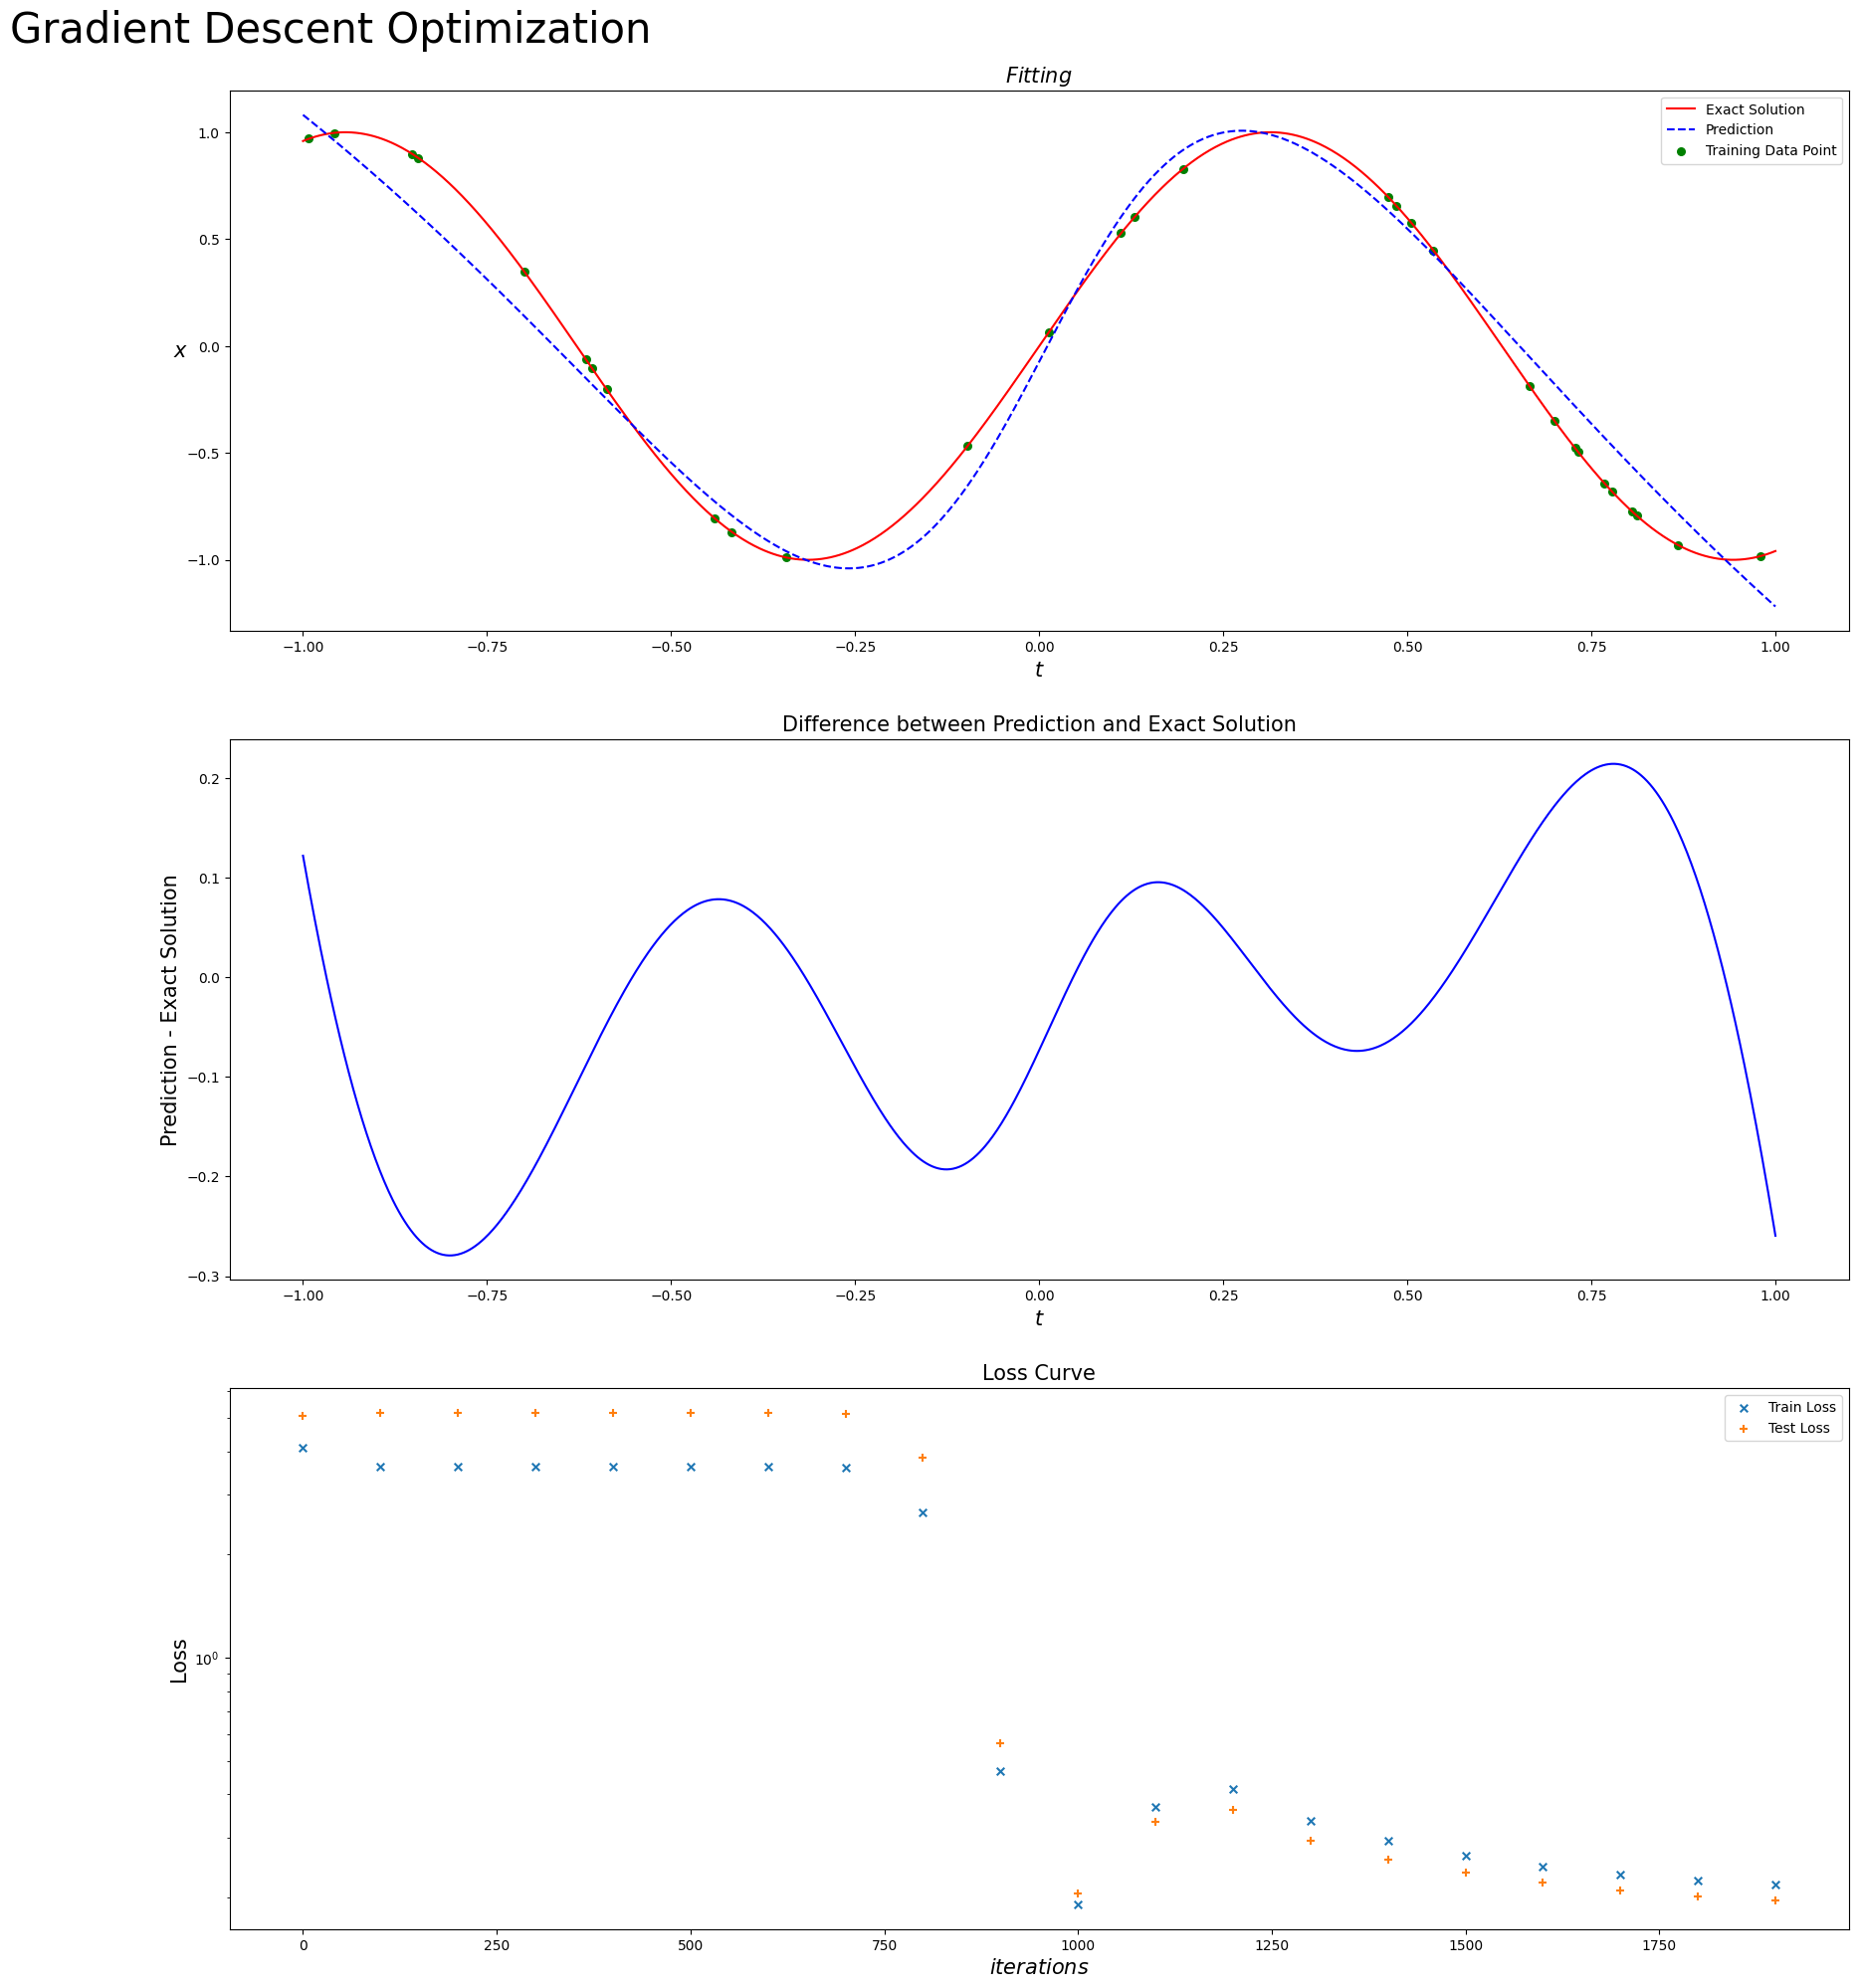

In [24]:
# Create data points and get random split of train, test data sets by index slicing

class NeuralNet_tanh:
    # Initialize the class
    def __init__(self, t_train, x_train, t_test, x_test, layers, t_min, t_max):
        self.t_train = t_train
        self.x_train = x_train
        self.t_test = t_test
        self.x_test = x_test
        self.loss_history = {"train": [], "test": []}

        # Initialize NNs with given number of layers and domain bounds [t_min, tmax]
        self.t_min = t_min
        self.t_max = t_max
        self.initialize_nn(layers)

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def initialize_nn(self, layers):
        """Functions used to establish the initial neural network"""
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32))
            weights.append(W)
            biases.append(b)
        self.weights = weights
        self.biases = biases
        self.trainable_variables = self.weights + self.biases

#changed activation function to tanh in the def net function
    def net(self, X):
        H = 2.0 * (X - self.t_min) / (self.t_max - self.t_min) - 1.0
        for l in range(0, len(self.weights) - 1):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b)) #here is where I changed tanh
        W = self.weights[-1]
        b = self.biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    @tf.function
    def loss_train(self):
        x_pred = self.net(self.t_train)
        loss = tf.reduce_mean(tf.square(self.x_train - x_pred)) * 10
        return loss

    @tf.function
    def loss_test(self):
        x_pred = self.net(self.t_test)
        loss = tf.reduce_mean(tf.square(self.x_test - x_pred)) * 10
        return loss

    def get_test_error(self):
        x_pred = self.net(self.t_test)
        error_x = tf.norm(self.x_test - x_pred, 2) / tf.norm(self.x_test, 2)
        return error_x

    def train(self, nIter: int, learning_rate: float, idxOpt: int):
      """Function used for training the model"""
      if idxOpt == 1:
          # mode 1: running the Gradient Descent optimization
          self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
      elif idxOpt == 2:
          # mode 2: running the Adam optimization
          self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      else:
          raise ValueError("Unsupported idxOpt")

      varlist = self.trainable_variables
      start_time = time.time()

      for it in range(nIter):
          with tf.GradientTape() as tape:
              loss_value = self.loss_train()

          # Compute gradients
          gradients = tape.gradient(loss_value, varlist)

          # Apply gradients
          self.optimizer.apply_gradients(zip(gradients, varlist))

          # Print training progress
          if it % 100 == 0:
              elapsed = time.time() - start_time
              loss_train = loss_value.numpy()
              loss_test = self.loss_test().numpy()
              self.loss_history["train"].append(loss_train)
              self.loss_history["test"].append(loss_test)
              print('It: %d, Train Loss: %.3e, Test Loss: %.3e, Time: %.2f' %
                    (it, loss_train, loss_test, elapsed))
              start_time = time.time()


n_total = 1000
train_ratio = 0.03
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
x_all = x = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices]
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet_tanh(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[1, 100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()
model.train(2000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

plot(t_all, x_all, pred_all, t_train, x_train, title="Gradient Descent Optimization")

3. When changing the activation function to tanh, the data no longer fits as well. When using this as an activation function we will likley need to increasing the training ratio to ensure we get a good NN prediction.

# Question 4


It: 0, Train Loss: 5.125e+00, Test Loss: 5.195e+00, Time: 0.18
It: 100, Train Loss: 4.913e+00, Test Loss: 5.015e+00, Time: 0.86
It: 200, Train Loss: 4.912e+00, Test Loss: 5.013e+00, Time: 0.86
It: 300, Train Loss: 4.911e+00, Test Loss: 5.012e+00, Time: 1.11
It: 400, Train Loss: 4.910e+00, Test Loss: 5.011e+00, Time: 1.20
It: 500, Train Loss: 4.909e+00, Test Loss: 5.010e+00, Time: 1.04
It: 600, Train Loss: 4.907e+00, Test Loss: 5.009e+00, Time: 0.84
It: 700, Train Loss: 4.904e+00, Test Loss: 5.006e+00, Time: 0.86
It: 800, Train Loss: 4.899e+00, Test Loss: 5.001e+00, Time: 0.83
It: 900, Train Loss: 4.880e+00, Test Loss: 4.984e+00, Time: 0.84
It: 1000, Train Loss: 2.949e+00, Test Loss: 2.709e+00, Time: 0.86
It: 1100, Train Loss: 7.879e-03, Test Loss: 1.038e-02, Time: 0.85
It: 1200, Train Loss: 6.970e-03, Test Loss: 9.088e-03, Time: 0.85
It: 1300, Train Loss: 6.316e-03, Test Loss: 8.338e-03, Time: 1.01
It: 1400, Train Loss: 5.794e-03, Test Loss: 7.735e-03, Time: 1.29
It: 1500, Train Loss: 

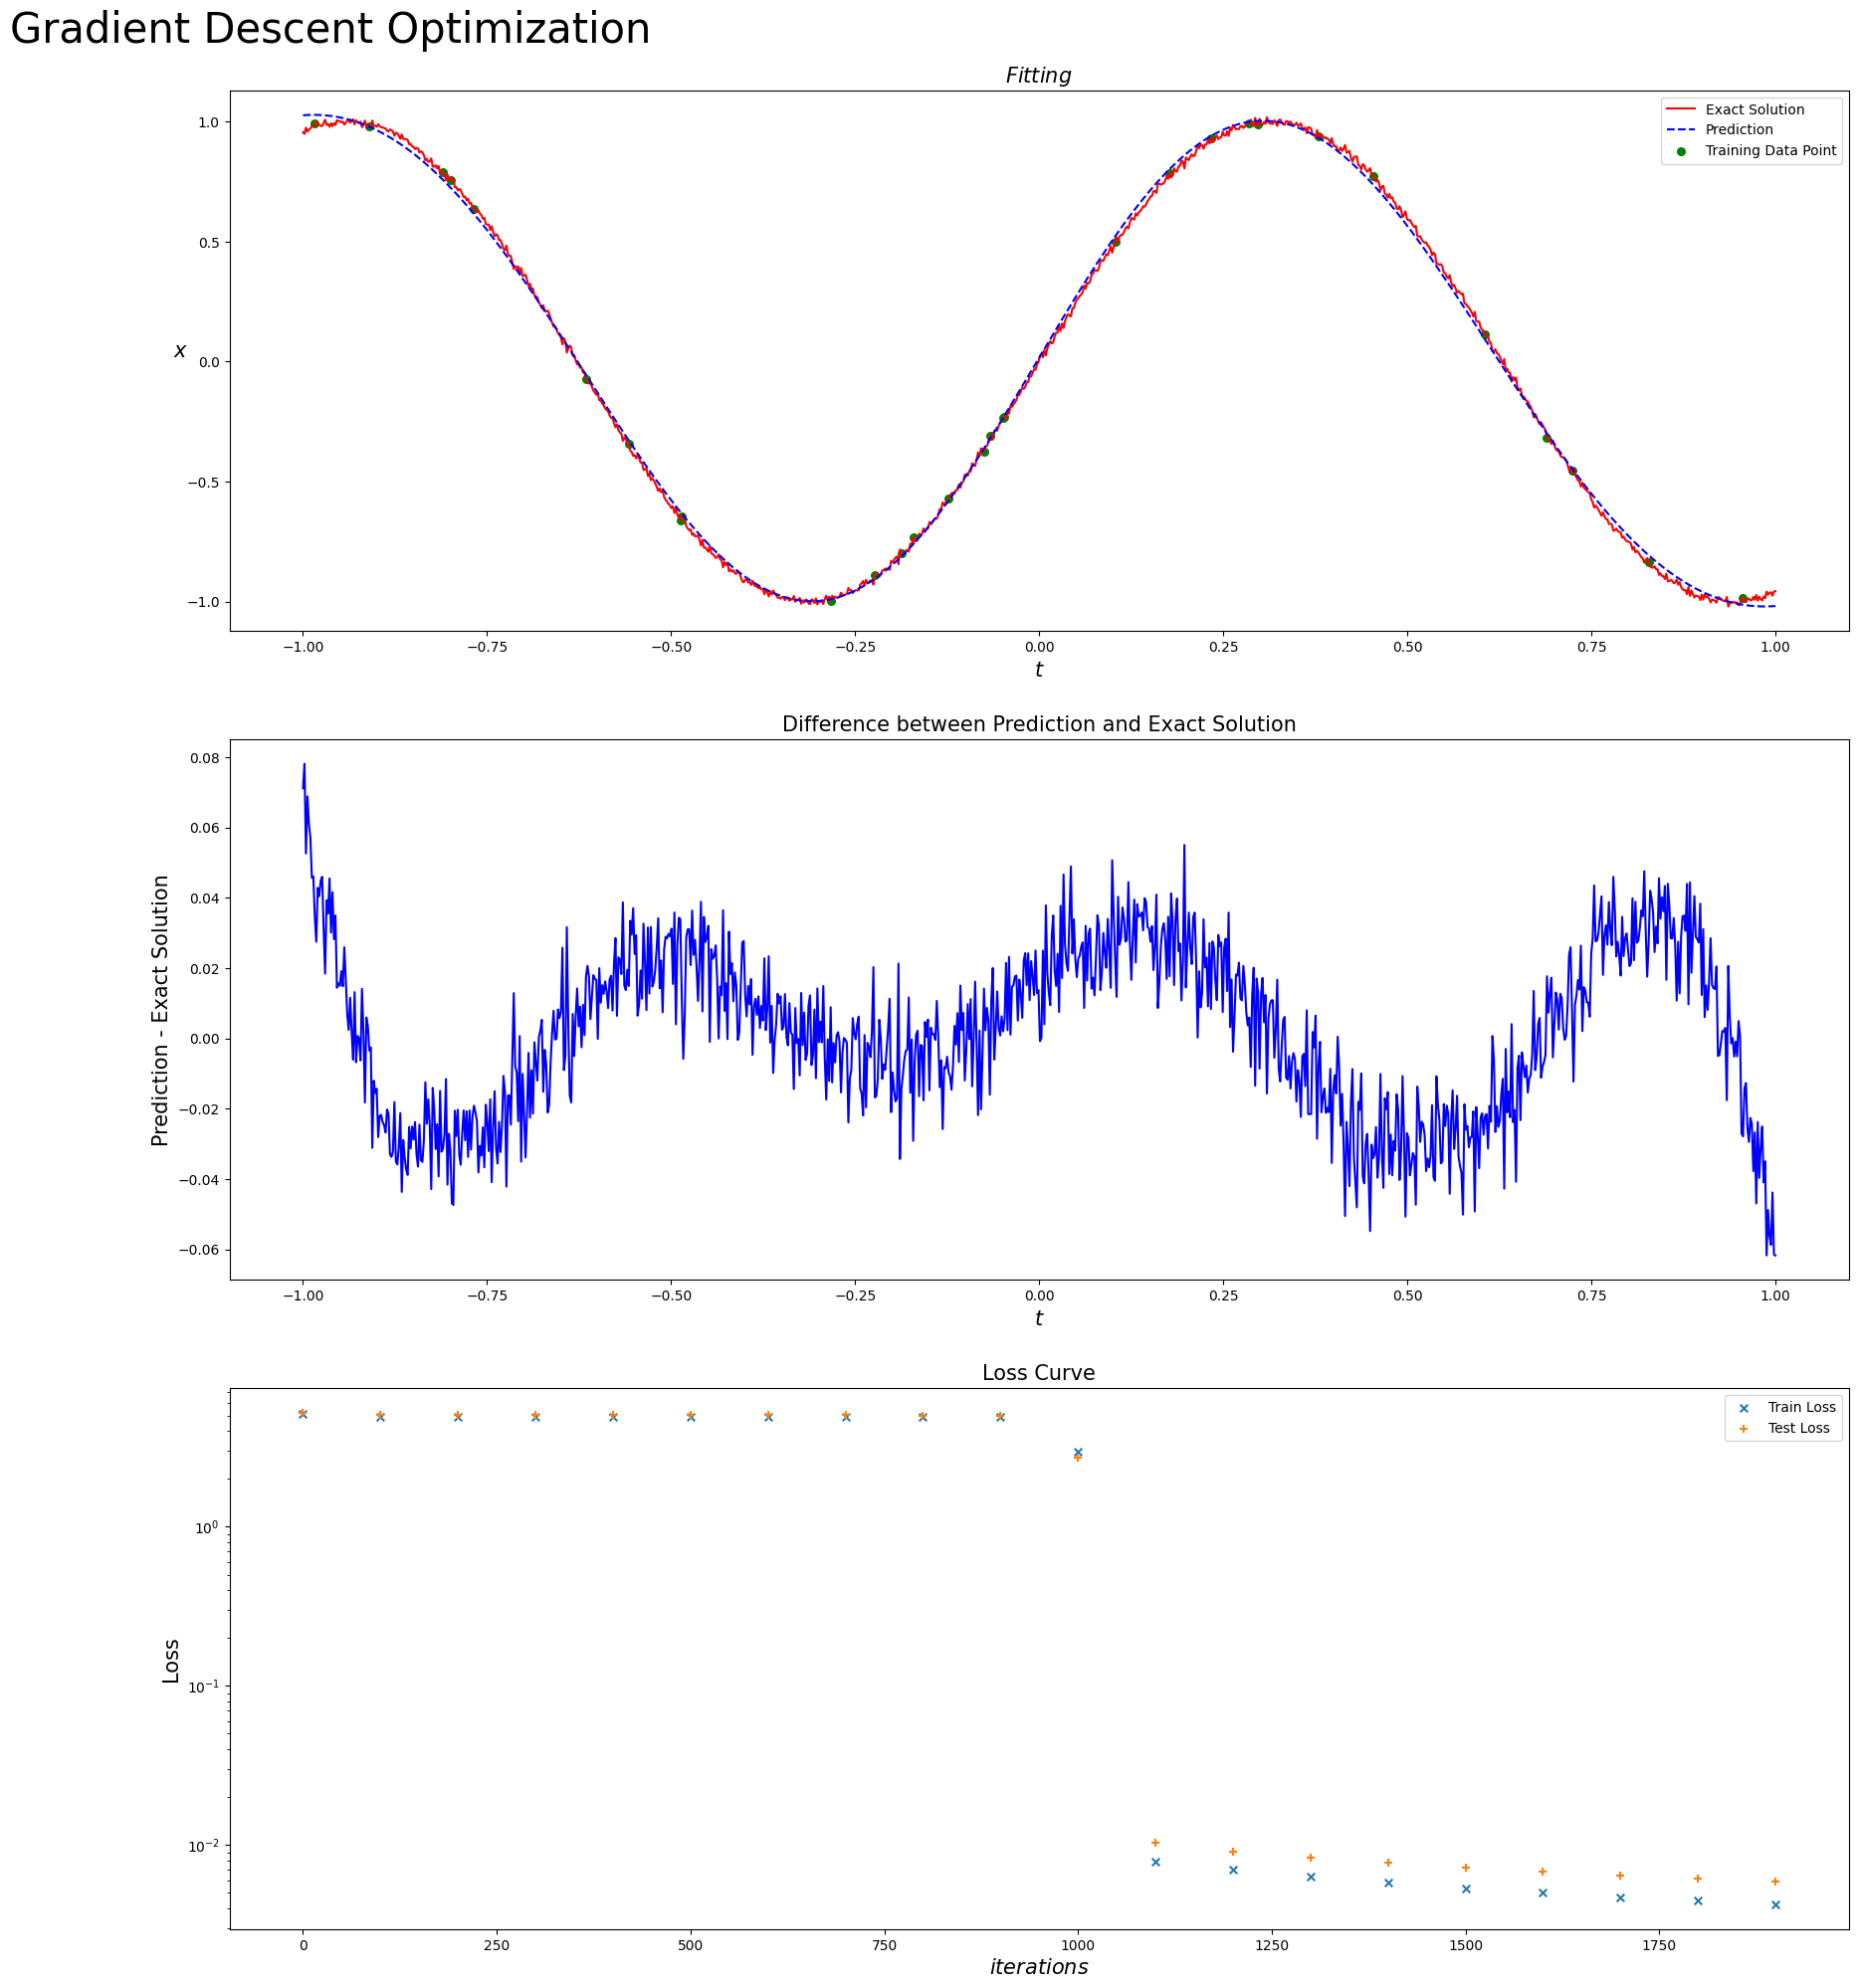

In [25]:
# Create data points and get random split of train, test data sets by index slicing
#noise magnitude 0.01
n_total = 1000
train_ratio = 0.03
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
x_all = x = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices] + np.random.normal(0, 0.01, size=np.shape(t_train))
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[1, 100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()
model.train(2000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

plot(t_all, x_all, pred_all, t_train, x_train, title="Gradient Descent Optimization")

It: 0, Train Loss: 5.845e+00, Test Loss: 6.410e+00, Time: 0.17
It: 100, Train Loss: 4.252e+00, Test Loss: 6.503e+00, Time: 0.85
It: 200, Train Loss: 4.250e+00, Test Loss: 6.500e+00, Time: 1.20
It: 300, Train Loss: 4.248e+00, Test Loss: 6.498e+00, Time: 1.21
It: 400, Train Loss: 4.246e+00, Test Loss: 6.495e+00, Time: 0.94
It: 500, Train Loss: 4.242e+00, Test Loss: 6.491e+00, Time: 0.84
It: 600, Train Loss: 4.236e+00, Test Loss: 6.483e+00, Time: 0.87
It: 700, Train Loss: 4.217e+00, Test Loss: 6.459e+00, Time: 0.86
It: 800, Train Loss: 4.044e+00, Test Loss: 6.225e+00, Time: 0.86
It: 900, Train Loss: 3.261e-01, Test Loss: 2.817e-01, Time: 0.98
It: 1000, Train Loss: 1.191e-01, Test Loss: 2.870e-03, Time: 1.97
It: 1100, Train Loss: 1.190e-01, Test Loss: 2.896e-03, Time: 1.41
It: 1200, Train Loss: 1.189e-01, Test Loss: 2.918e-03, Time: 1.36
It: 1300, Train Loss: 1.188e-01, Test Loss: 2.942e-03, Time: 2.44
It: 1400, Train Loss: 1.187e-01, Test Loss: 2.970e-03, Time: 2.39
It: 1500, Train Loss: 

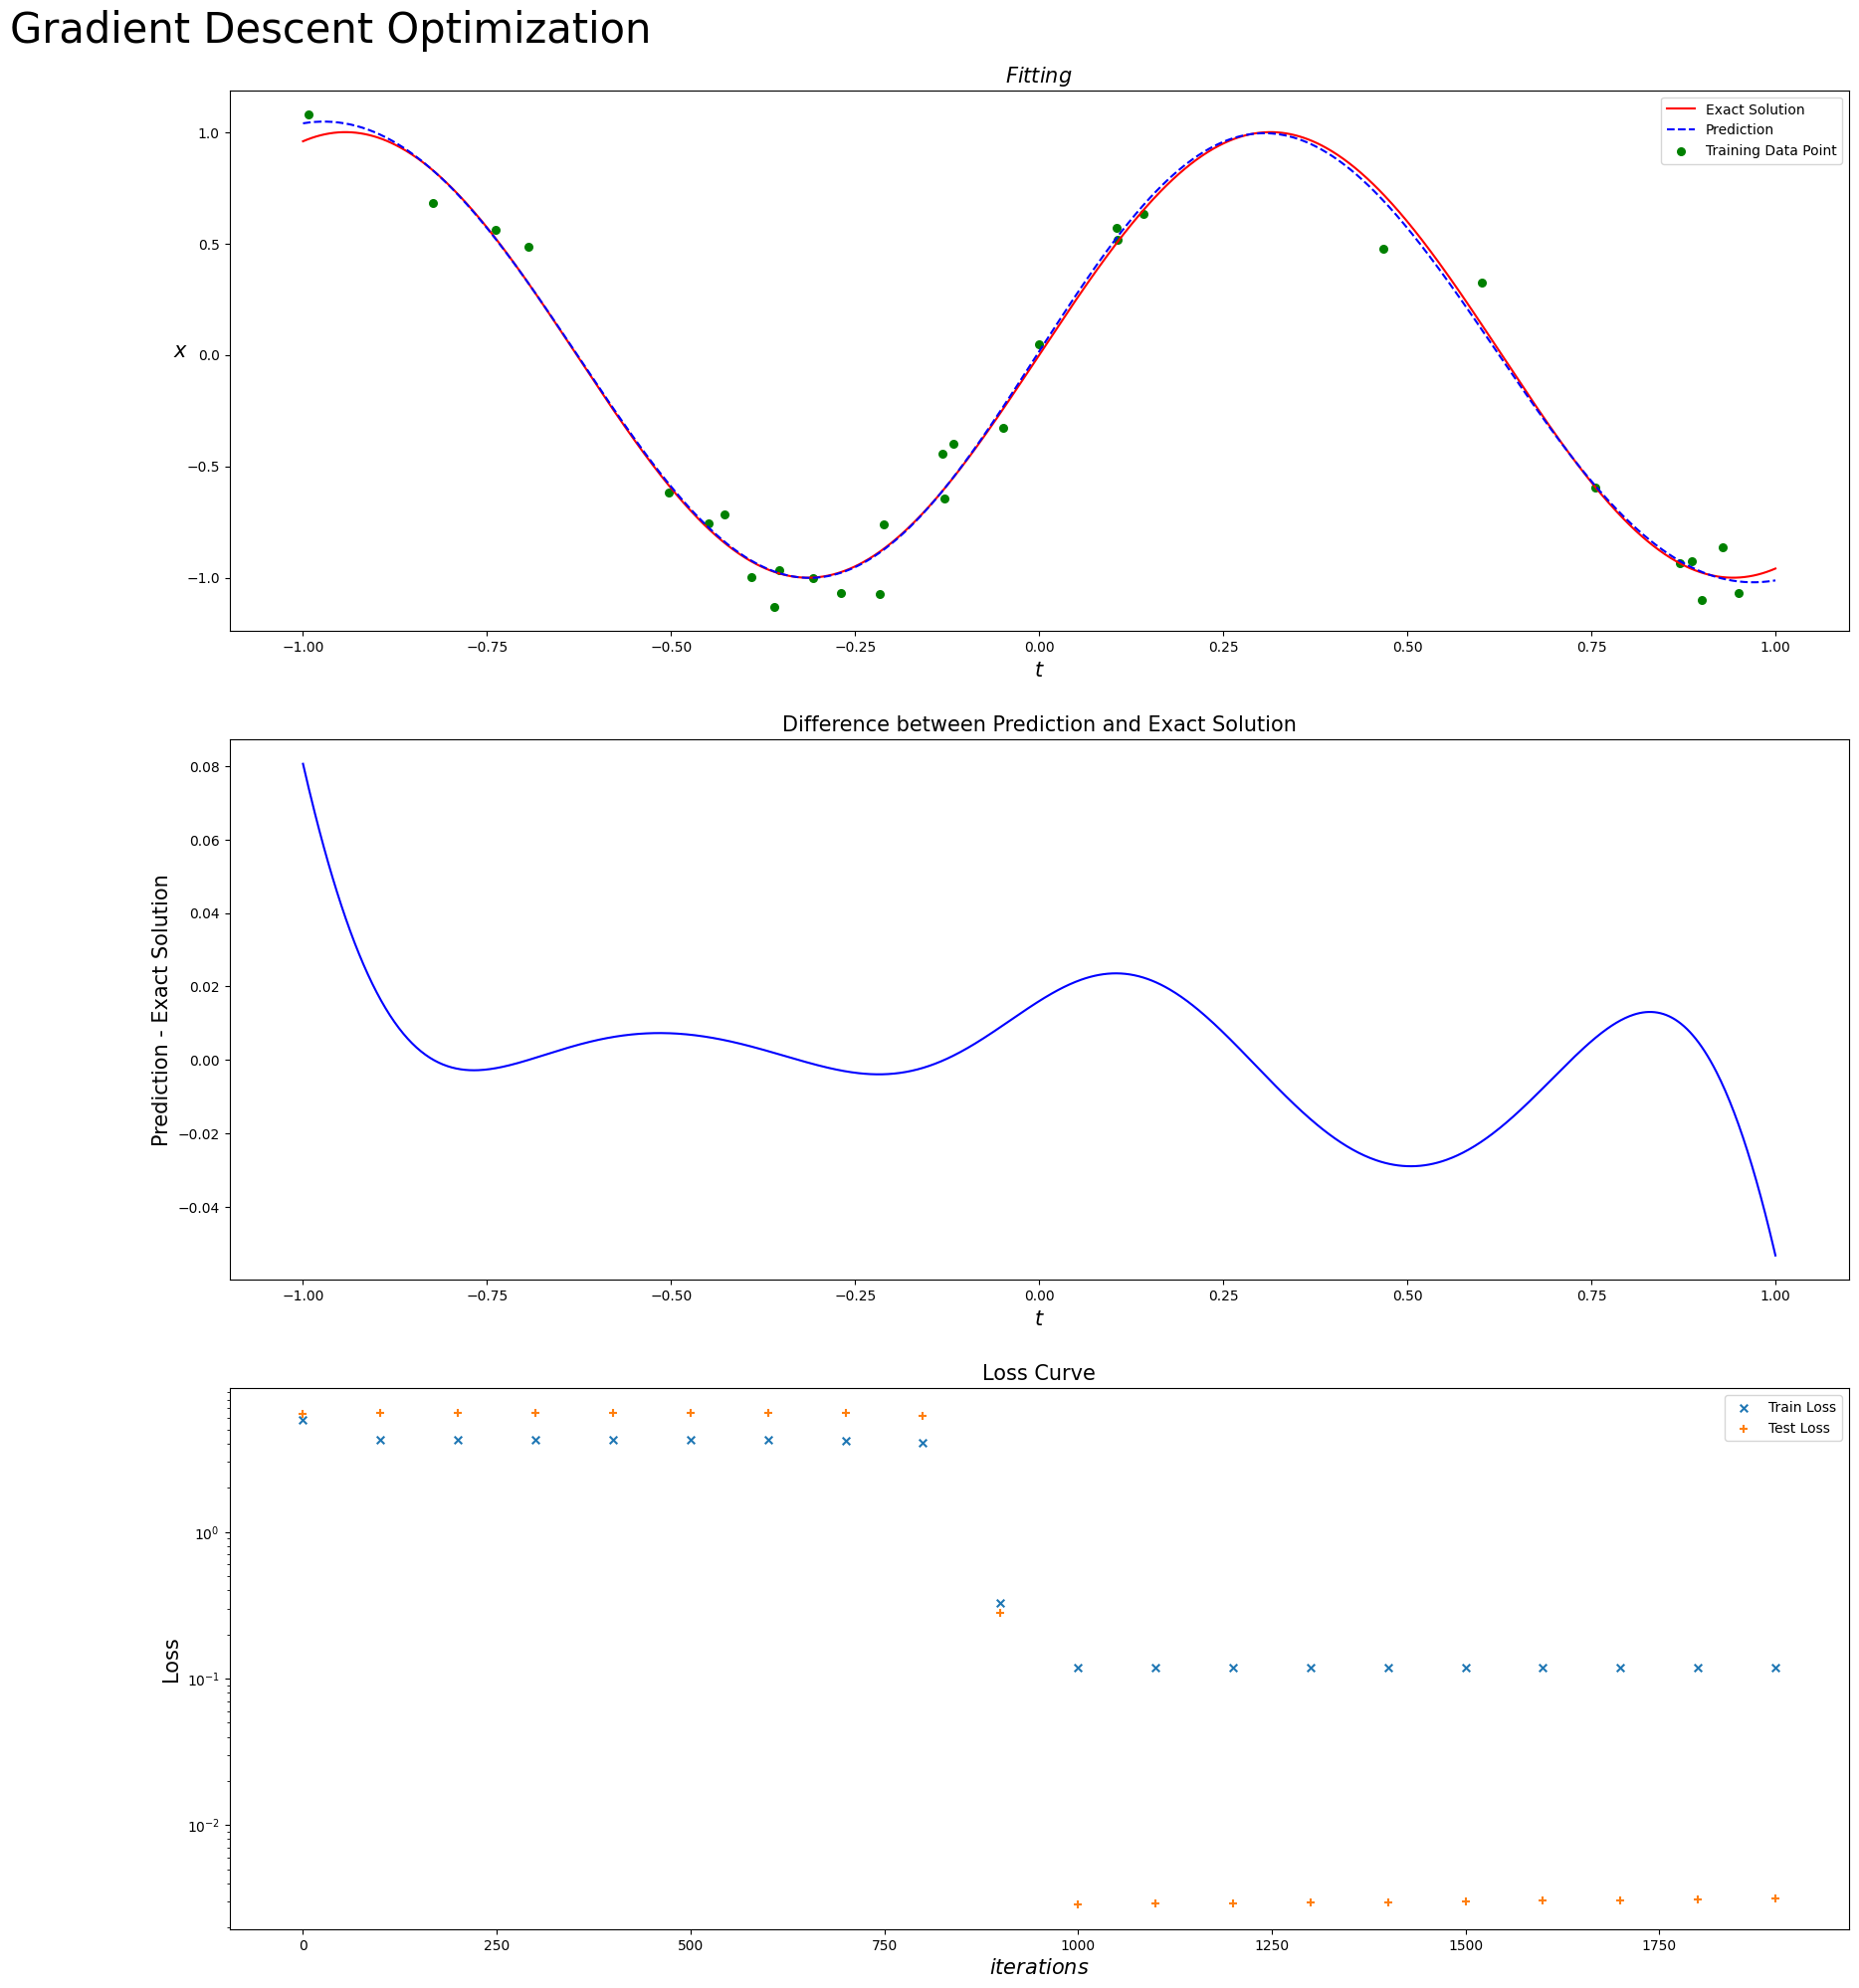

In [28]:
# Create data points and get random split of train, test data sets by index slicing
#noise magnitude 0.1
n_total = 1000
train_ratio = 0.03
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
x_all = x = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices] + np.random.normal(0, 0.1, size=np.shape(t_train))
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[1, 100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()
model.train(2000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

plot(t_all, x_all, pred_all, t_train, x_train, title="Gradient Descent Optimization")

It: 0, Train Loss: 2.302e+01, Test Loss: 6.163e+00, Time: 0.28
It: 100, Train Loss: 2.238e+01, Test Loss: 6.640e+00, Time: 0.88
It: 200, Train Loss: 2.237e+01, Test Loss: 6.641e+00, Time: 0.85
It: 300, Train Loss: 2.235e+01, Test Loss: 6.640e+00, Time: 0.87
It: 400, Train Loss: 1.560e+01, Test Loss: 1.182e+01, Time: 0.88
It: 500, Train Loss: 1.054e+01, Test Loss: 4.338e+00, Time: 0.86
It: 600, Train Loss: 9.452e+00, Test Loss: 7.353e+00, Time: 0.86
It: 700, Train Loss: 8.946e+00, Test Loss: 5.979e+00, Time: 0.83
It: 800, Train Loss: 8.238e+00, Test Loss: 6.428e+00, Time: 1.04
It: 900, Train Loss: 8.168e+00, Test Loss: 6.452e+00, Time: 1.23
It: 1000, Train Loss: 7.930e+00, Test Loss: 6.010e+00, Time: 1.09
It: 1100, Train Loss: 7.994e+00, Test Loss: 6.033e+00, Time: 0.83
It: 1200, Train Loss: 7.863e+00, Test Loss: 6.463e+00, Time: 0.84
It: 1300, Train Loss: 8.159e+00, Test Loss: 7.285e+00, Time: 0.84
It: 1400, Train Loss: 8.060e+00, Test Loss: 7.275e+00, Time: 0.84
It: 1500, Train Loss: 

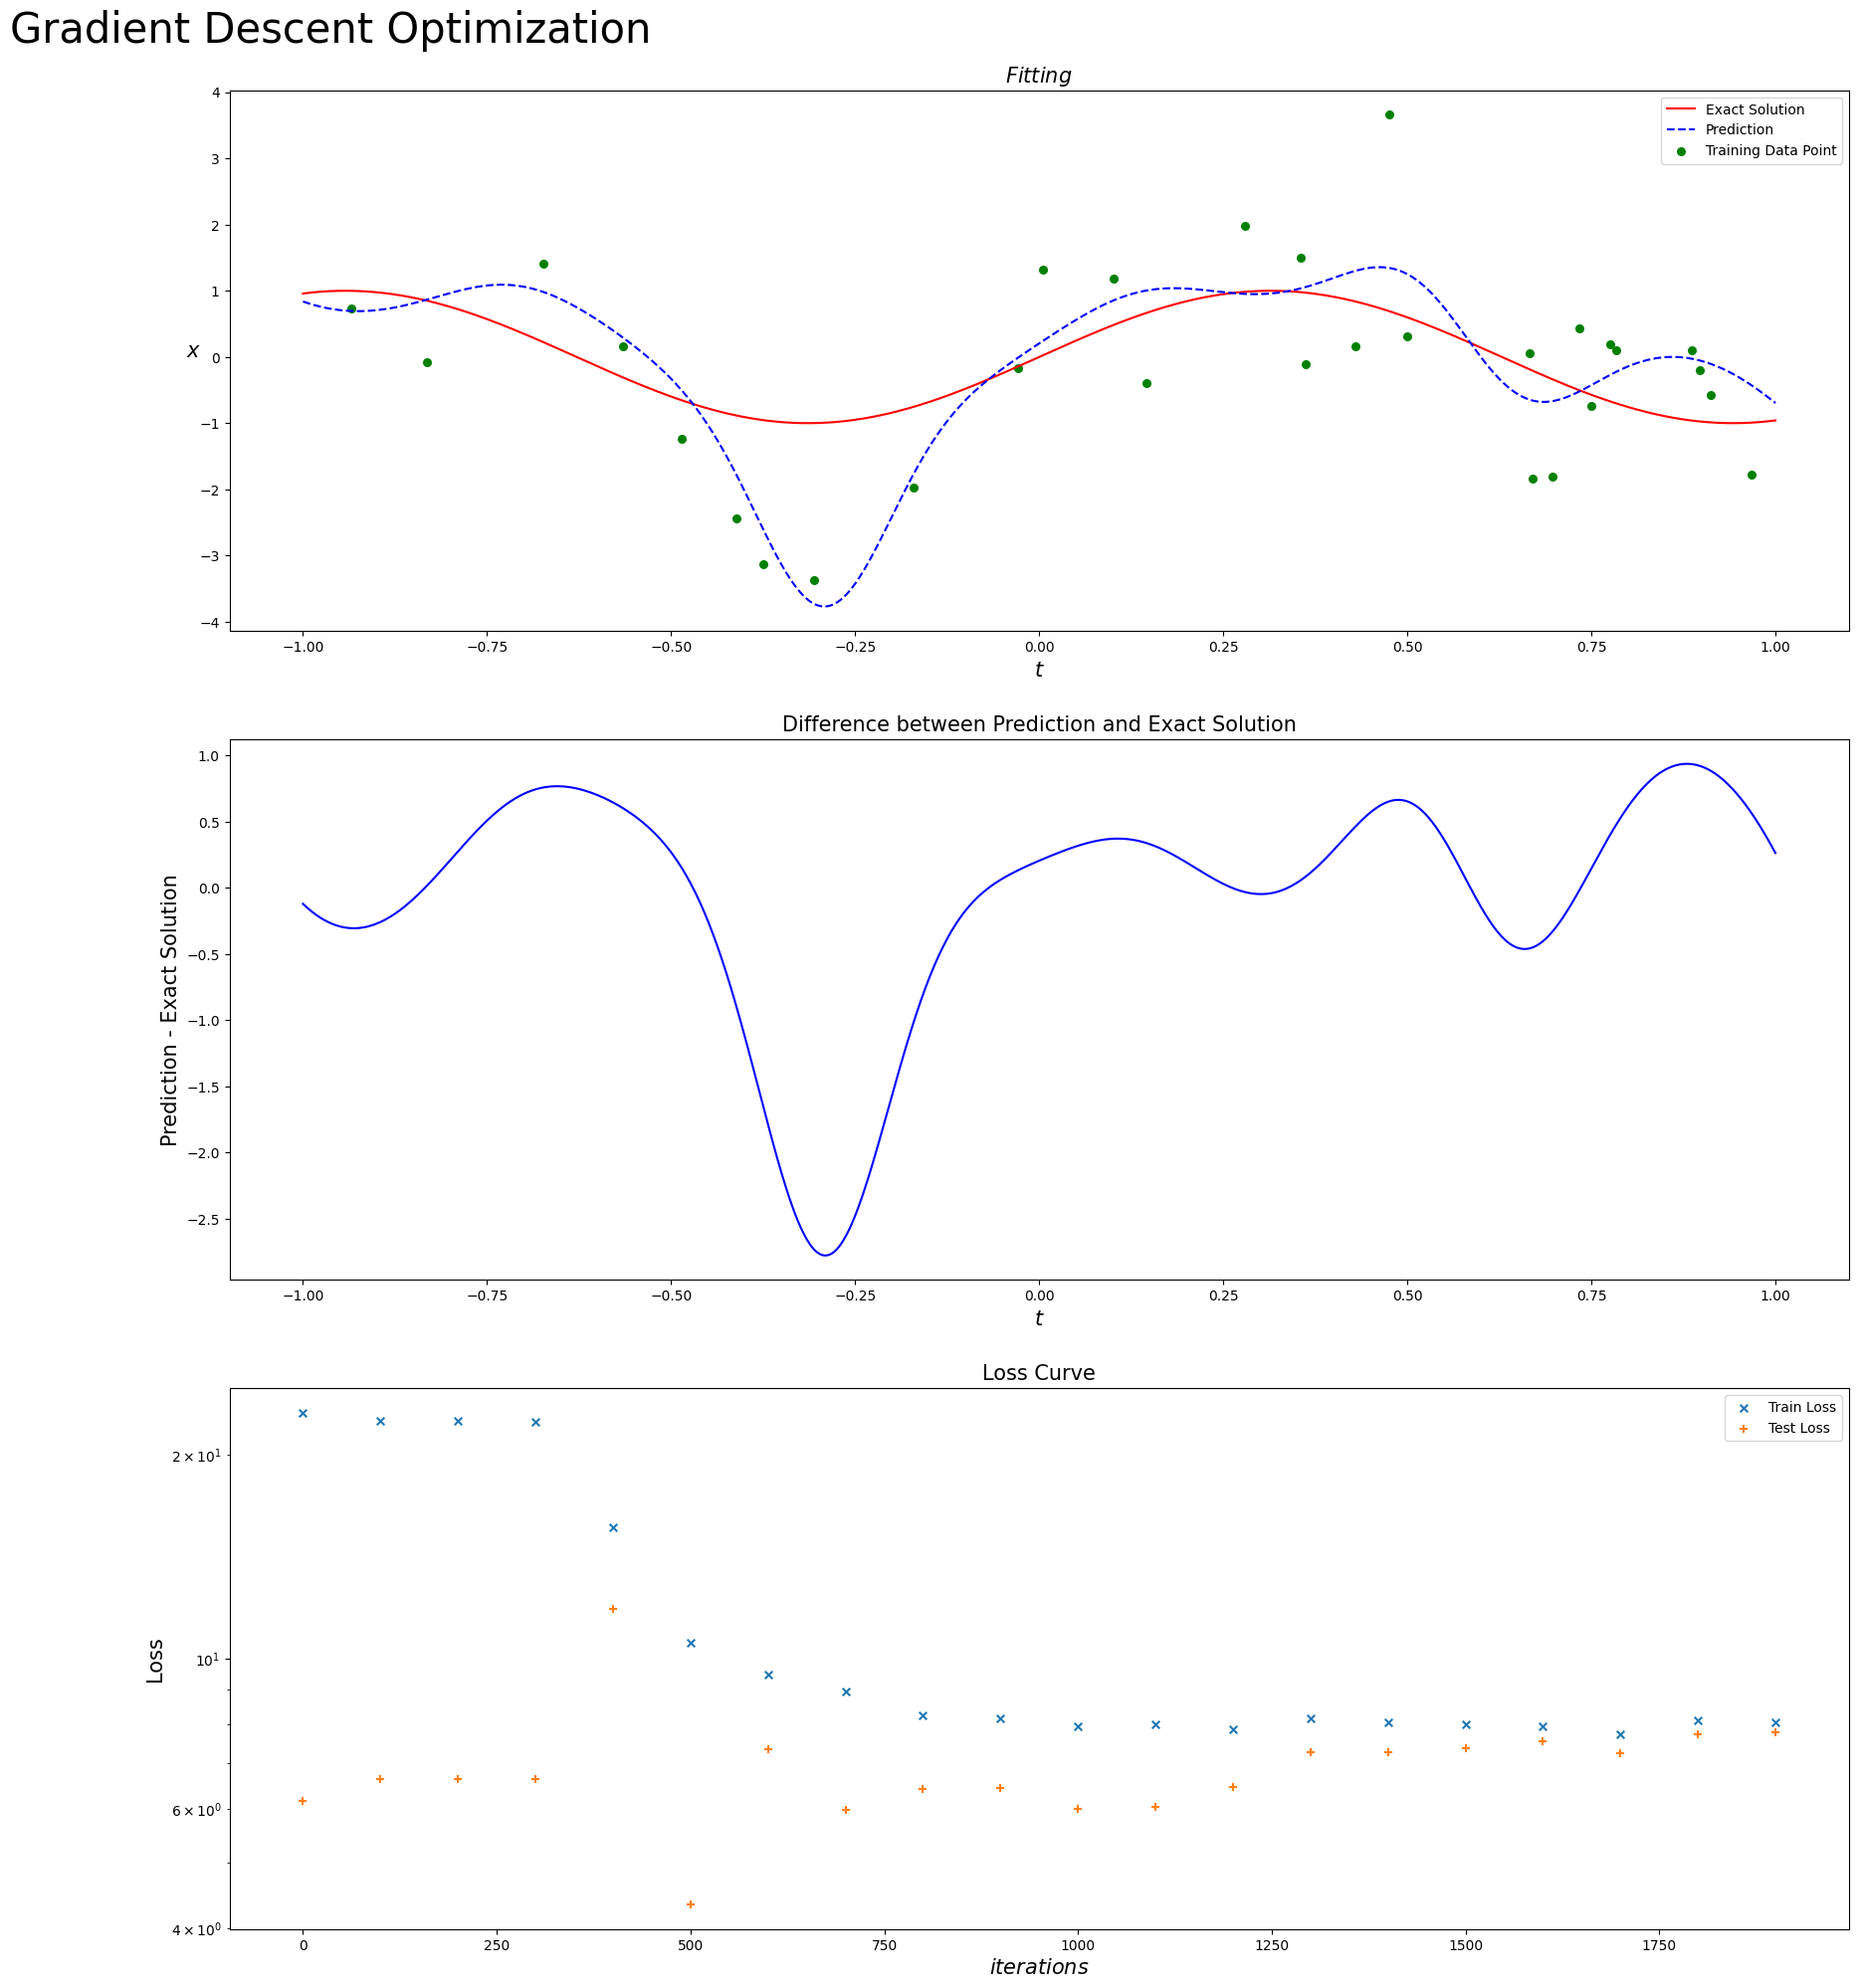

In [29]:
# Create data points and get random split of train, test data sets by index slicing
#noise magnitude 1
n_total = 1000
train_ratio = 0.03
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
x_all = x = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices] + np.random.normal(0, 1, size=np.shape(t_train))
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[1, 100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()
model.train(2000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

plot(t_all, x_all, pred_all, t_train, x_train, title="Gradient Descent Optimization")

# Question 5

It: 0, Train Loss: 1.443e+01, Test Loss: 4.924e+00, Time: 0.32
It: 100, Train Loss: 1.422e+01, Test Loss: 4.975e+00, Time: 1.87
It: 200, Train Loss: 1.422e+01, Test Loss: 4.974e+00, Time: 1.78
It: 300, Train Loss: 1.422e+01, Test Loss: 4.972e+00, Time: 1.72
It: 400, Train Loss: 1.422e+01, Test Loss: 4.971e+00, Time: 1.34
It: 500, Train Loss: 1.421e+01, Test Loss: 4.969e+00, Time: 1.30
It: 600, Train Loss: 1.421e+01, Test Loss: 4.967e+00, Time: 1.31
It: 700, Train Loss: 1.421e+01, Test Loss: 4.962e+00, Time: 1.31
It: 800, Train Loss: 1.419e+01, Test Loss: 4.946e+00, Time: 1.32
It: 900, Train Loss: 1.360e+01, Test Loss: 4.271e+00, Time: 1.32
It: 1000, Train Loss: 9.962e+00, Test Loss: 4.159e-01, Time: 1.31
It: 1100, Train Loss: 9.765e+00, Test Loss: 1.098e-01, Time: 1.88
It: 1200, Train Loss: 9.765e+00, Test Loss: 1.089e-01, Time: 1.72
It: 1300, Train Loss: 9.765e+00, Test Loss: 1.090e-01, Time: 1.32
It: 1400, Train Loss: 9.765e+00, Test Loss: 1.091e-01, Time: 1.30
It: 1500, Train Loss: 

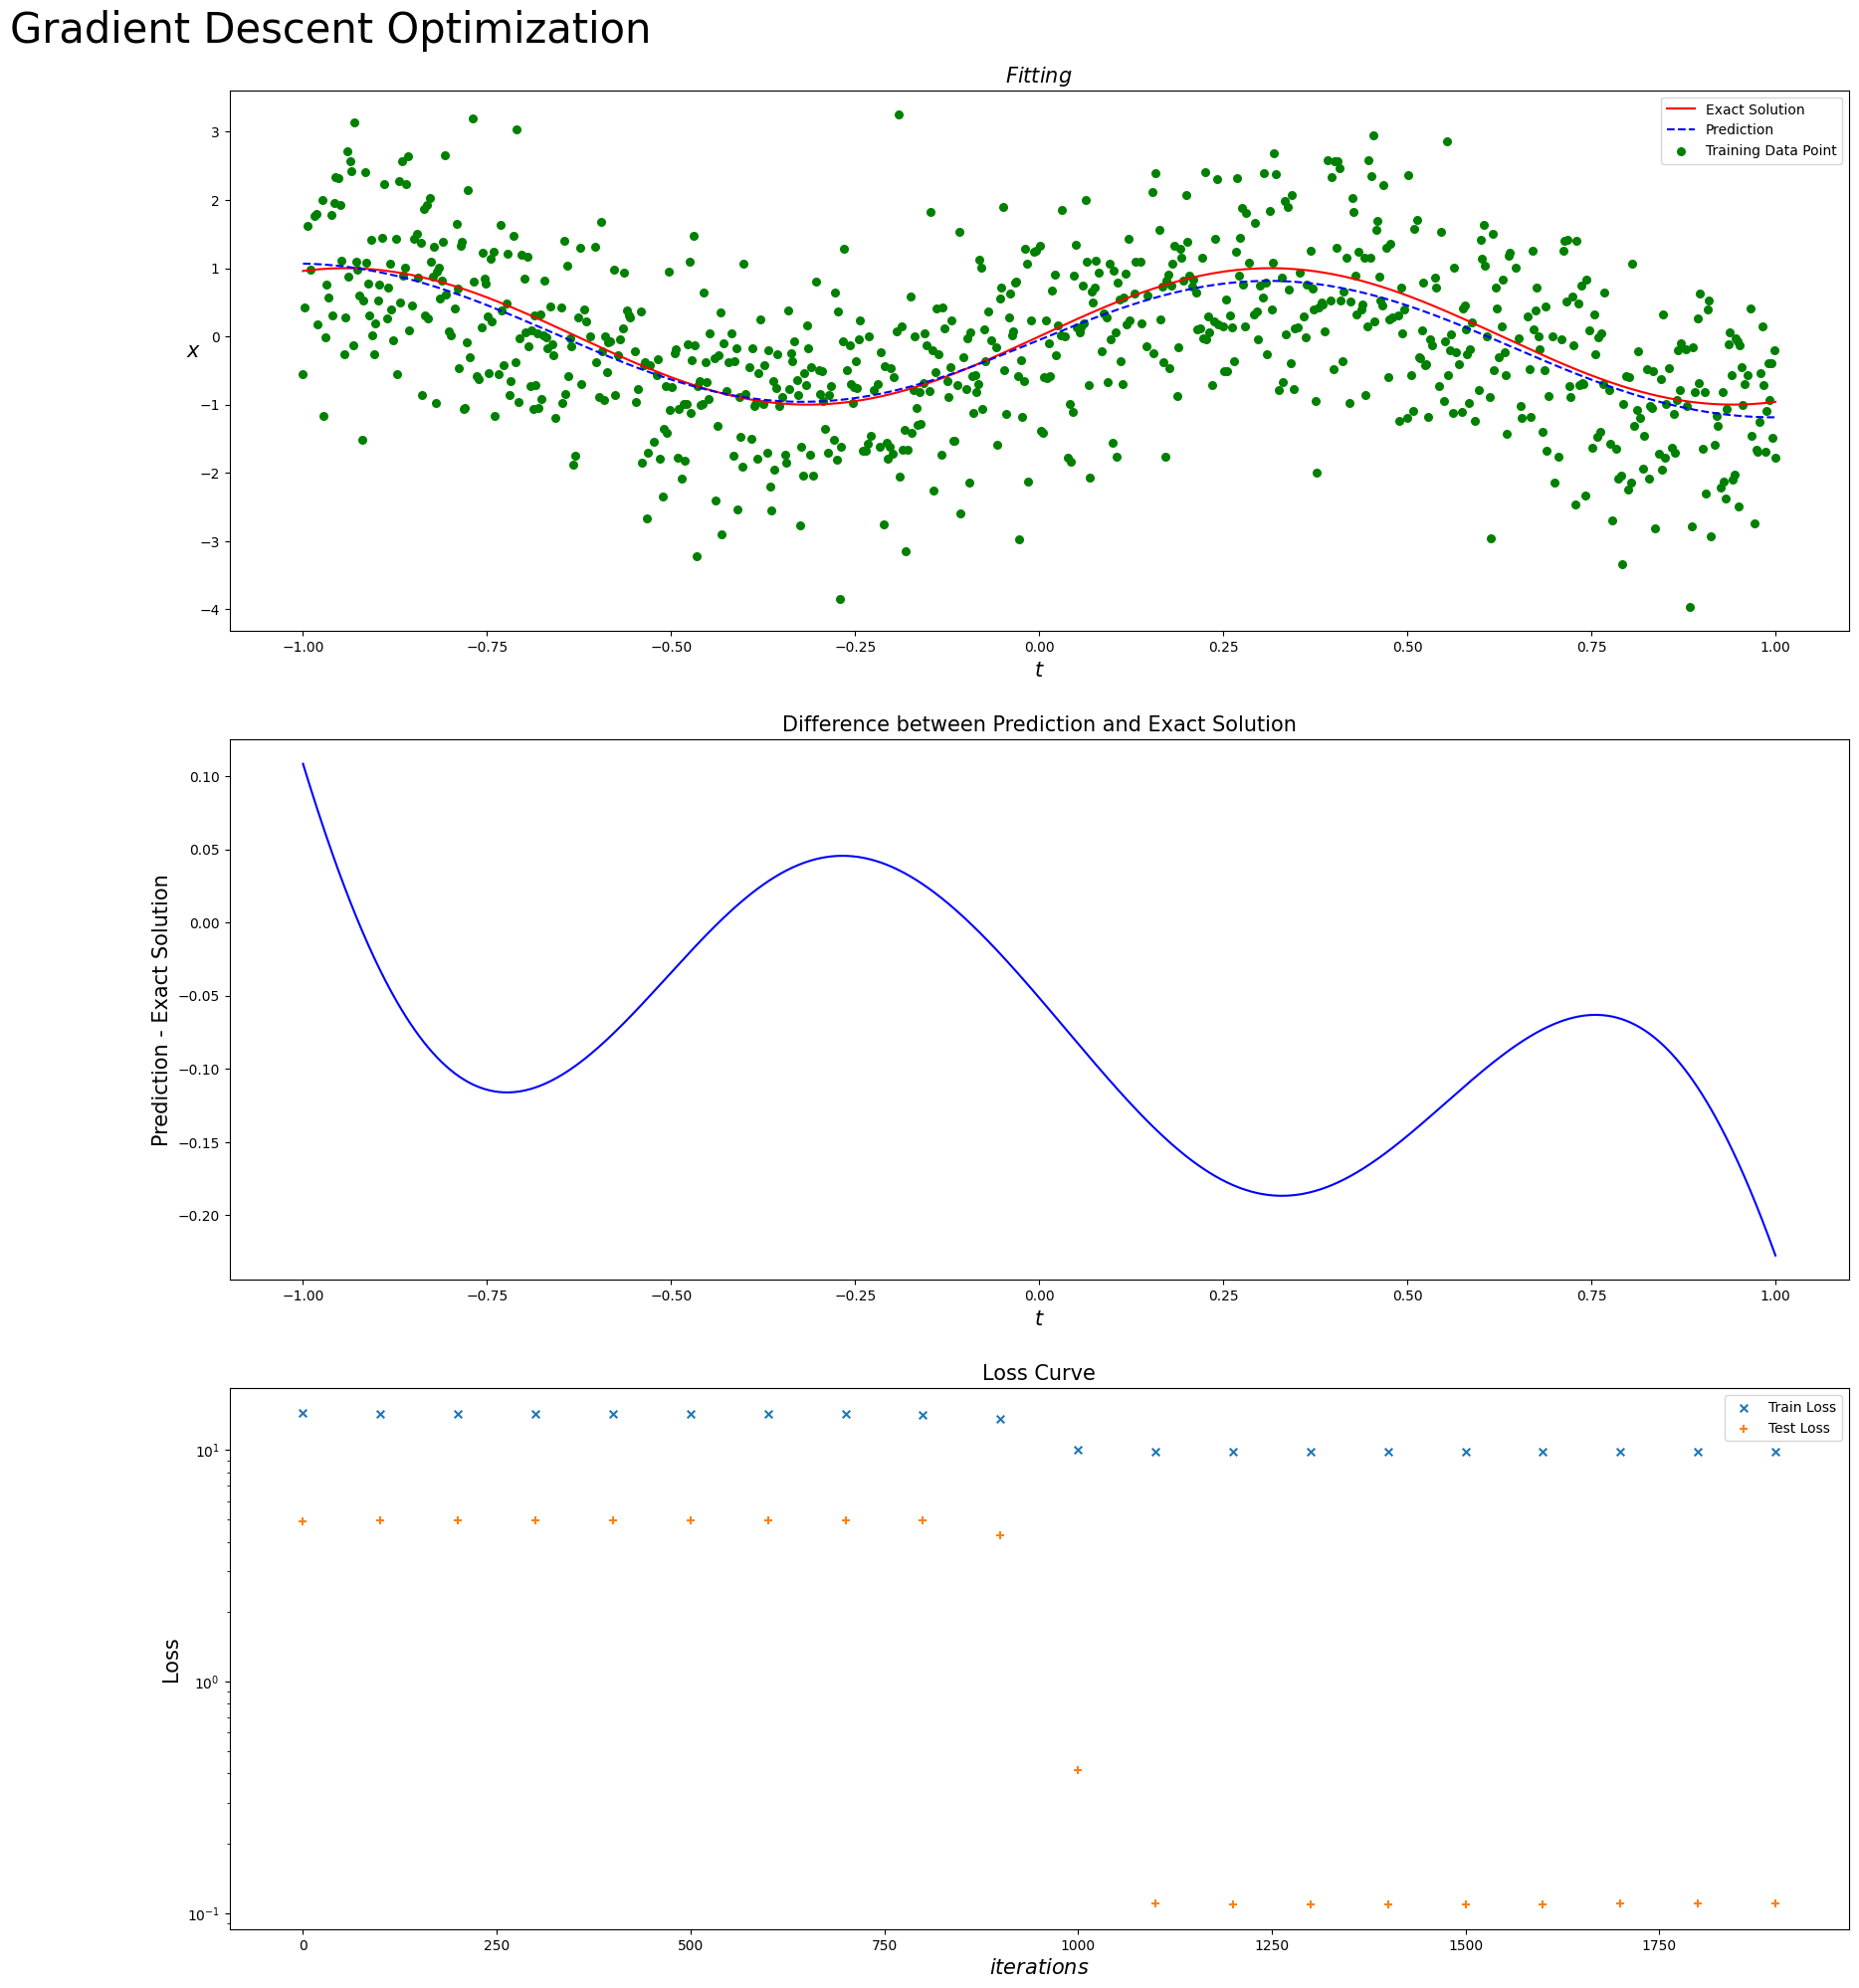

In [31]:
# Create data points and get random split of train, test data sets by index slicing
#noise magnitude 1
n_total = 1000
train_ratio = 0.8
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
x_all = x = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices] + np.random.normal(0, 1, size=np.shape(t_train))
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[1, 100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()
model.train(2000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

plot(t_all, x_all, pred_all, t_train, x_train, title="Gradient Descent Optimization")